In [1]:
!pip install pystan==2.19
!pip install fbprophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler 

import pylab
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/borsa_study

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/borsa_study


In [3]:
sumas = pd.read_csv('stock_history/SUMAS.IS/SUMAS.IS_2018_2021.csv', header=0,index_col=0,parse_dates=True, squeeze=True)
sumas.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-02-09,10.0,10.0,10.0,10.0,82
2018-02-12,10.0,10.0,10.0,10.0,662
2018-02-13,8.5,8.5,8.0,8.0,165
2018-02-14,7.9,7.9,7.7,7.7,73
2018-02-15,7.4,7.4,7.4,7.4,38


In [4]:
plt.rcParams["figure.figsize"] = (7.5,5)
plt.style.use('seaborn')

pylab.rc('figure', figsize=(10,7))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

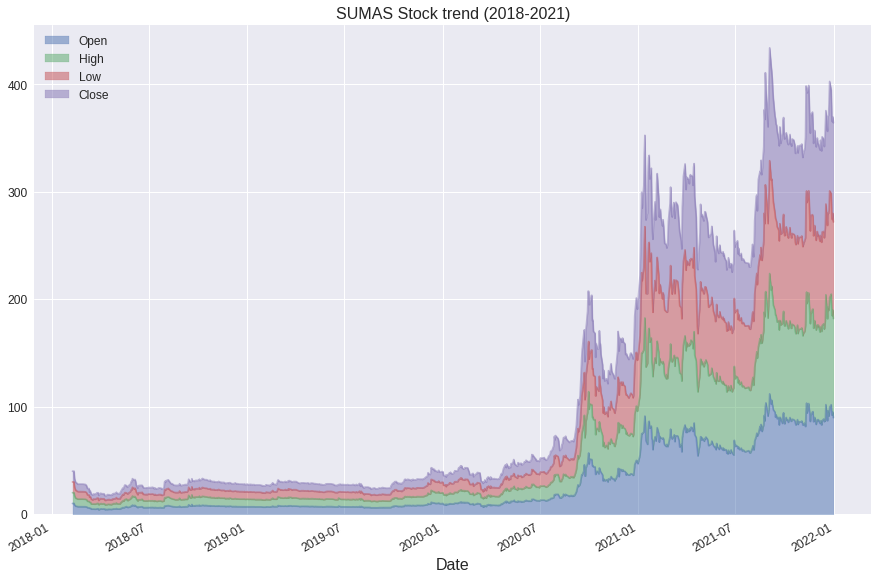

In [5]:
sumas[['Open','High','Low','Close']].plot.area(figsize=(15,10), alpha=0.5)
plt.title('SUMAS Stock trend (2018-2021)')
plt.show()

We are going to focus only on the Opening stocks and ignore the Highs, Lows and Close prices.

In [6]:
sumas = sumas['Open']

In [7]:
groups = sumas.groupby(pd.Grouper(freq='A'))

yearsd={}
for name, group in groups:
  yearsd[name.year] = group.values

yearsd[2018]=np.append(yearsd[2018],yearsd[2018][-1]) ## Keeping the number of days same. Just to visualise the yearly data
yearsd[2019]=np.append(yearsd[2019],yearsd[2019][-1]) 
yearsd[2020]=np.append(yearsd[2020],yearsd[2020][-1]) 
yearsd[2021]=np.append(yearsd[2021],yearsd[2021][-1]) 
print(len(yearsd[2018]), len(yearsd[2019]), len(yearsd[2020]), len(yearsd[2021]))

years18=pd.DataFrame(yearsd[2018], columns=['2018'])
years19=pd.DataFrame(yearsd[2019], columns=['2019'])
years20=pd.DataFrame(yearsd[2020], columns=['2020'])
years21=pd.DataFrame(yearsd[2021], columns=['2021'])
years = pd.DataFrame()
years['2018'] = years18['2018']
years['2019'] = years19['2019']
years['2020'] = years20['2020']
years['2021'] = years21['2021']
years.head()
years.describe()


233 261 253 250


,2018,2019,2020,2021
count,233.000000,233.000000,233.000000,233.000000
mean,6.674206,7.006438,18.766137,75.620386
std,1.143785,0.574731,12.407958,12.722935
min,4.000000,5.900000,6.500000,54.200001
25%,6.020000,6.740000,9.920000,64.199997
50%,6.970000,6.960000,12.550000,74.099998
75%,7.490000,7.300000,27.459999,86.050003
max,10.000000,8.200000,57.000000,112.000000


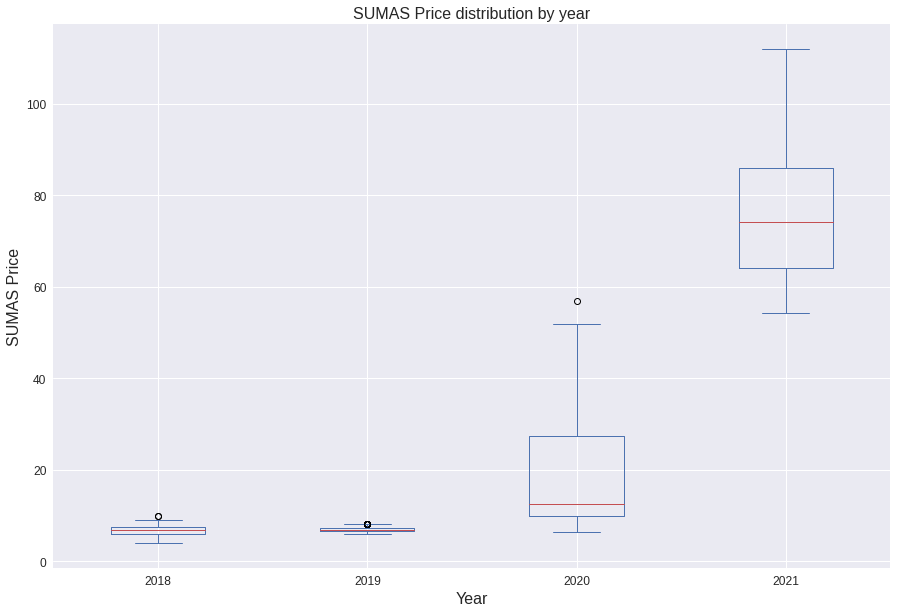

In [8]:
years.plot.box(figsize=(15,10))
plt.title('SUMAS Price distribution by year')
plt.ylabel('SUMAS Price')
plt.xlabel('Year')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


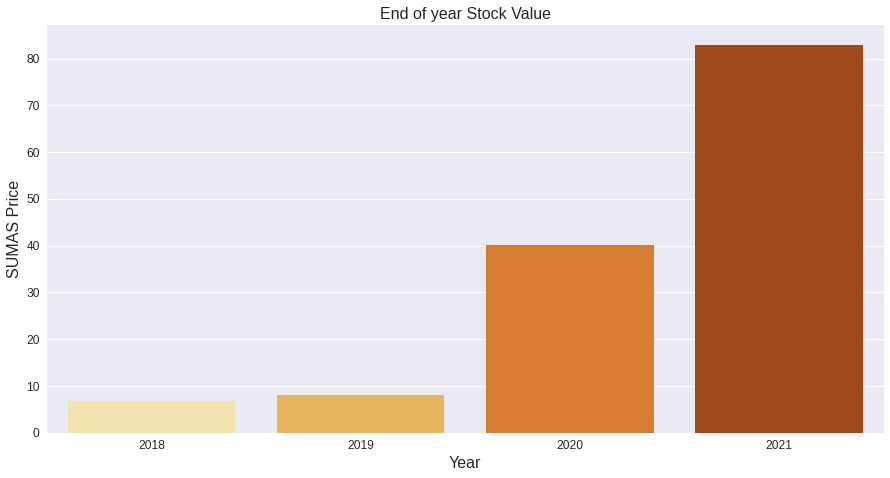

In [9]:
plt.figure(figsize=(15,7.5))
sns.barplot(years.iloc[-1,:].index,years.iloc[-1,:].values,palette='YlOrBr')
plt.title('End of year Stock Value')
plt.ylabel('SUMAS Price')
plt.xlabel('Year')
plt.show()

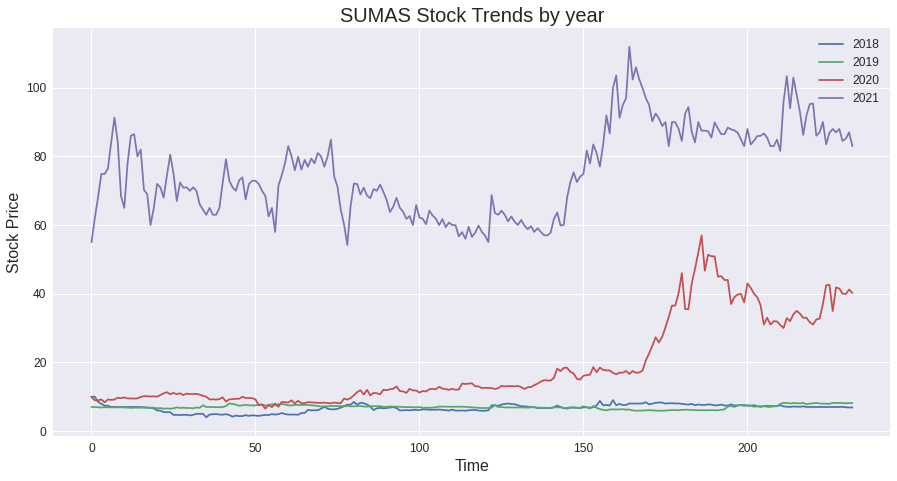

In [10]:
years.plot(figsize=(15,7.5))
plt.title('SUMAS Stock Trends by year',fontsize=20)
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.show()

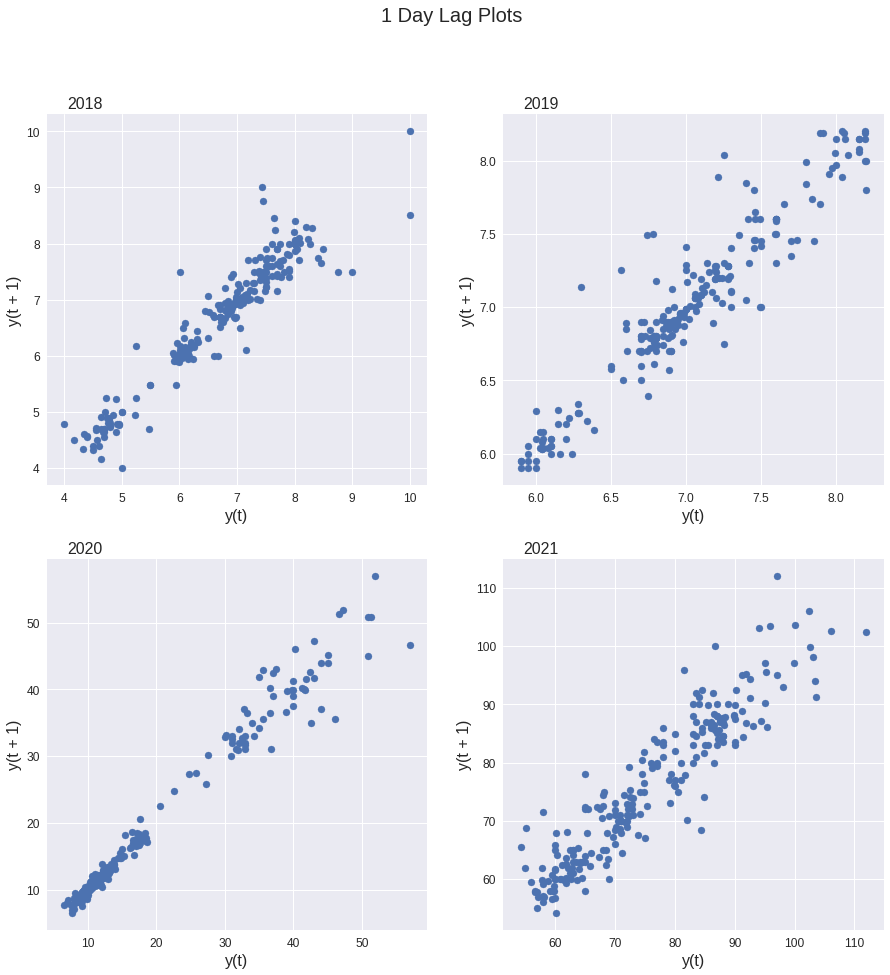

In [11]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,15))
pd.plotting.lag_plot(years['2018'],ax=ax[0,0],lag=1)
pd.plotting.lag_plot(years['2019'],ax=ax[0,1],lag=1)
pd.plotting.lag_plot(years['2020'],ax=ax[1,0],lag=1)
pd.plotting.lag_plot(years['2021'],ax=ax[1,1],lag=1)
fig.suptitle('1 Day Lag Plots',fontsize=20)
ax[0,0].set_title('2018',X=0.1)
ax[0,1].set_title('2019',X=0.1)
ax[1,0].set_title('2020',X=0.1)
ax[1,1].set_title('2021',X=0.1)
plt.show()

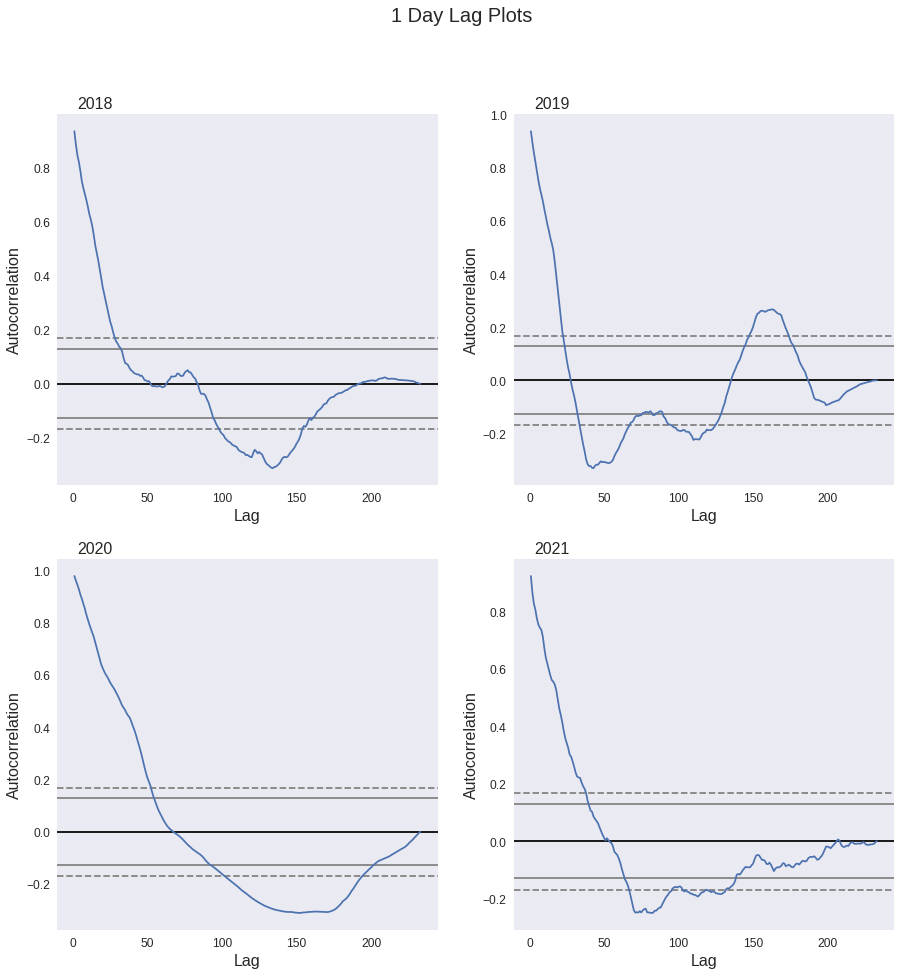

In [12]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,15))
pd.plotting.autocorrelation_plot(years['2018'],ax=ax[0,0])
pd.plotting.autocorrelation_plot(years['2019'],ax=ax[0,1])
pd.plotting.autocorrelation_plot(years['2020'],ax=ax[1,0])
pd.plotting.autocorrelation_plot(years['2021'],ax=ax[1,1])
fig.suptitle('1 Day Lag Plots',fontsize=20)
ax[0,0].set_title('2018',X=0.1)
ax[0,1].set_title('2019',X=0.1)
ax[1,0].set_title('2020',X=0.1)
ax[1,1].set_title('2021',X=0.1)
plt.show()

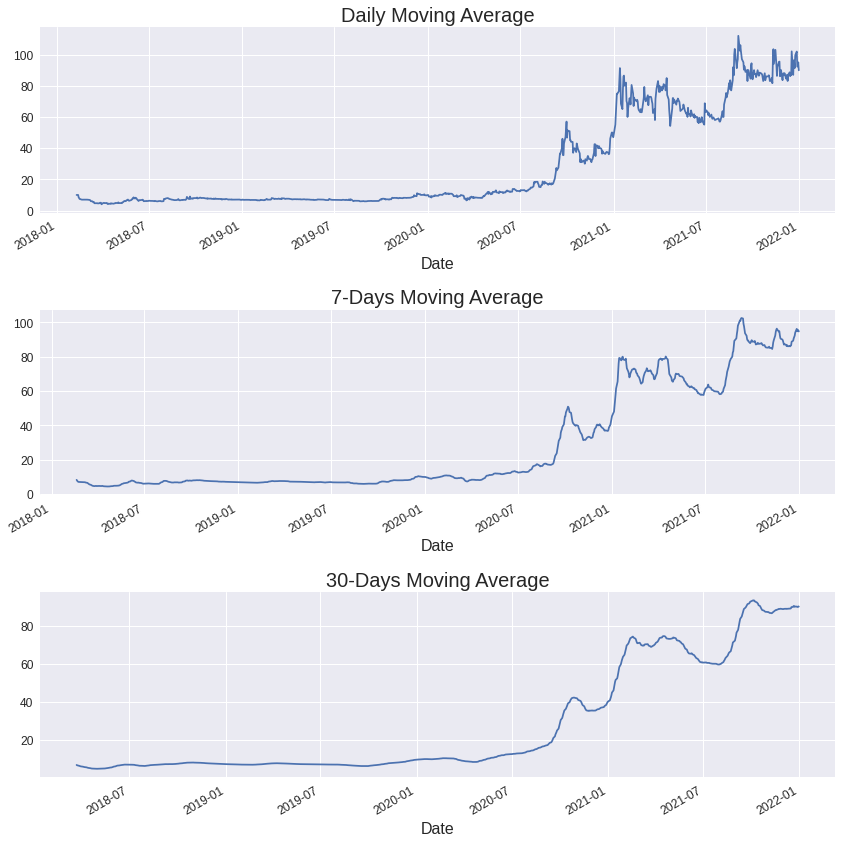

In [13]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(12,12))
sumas.rolling(window=1).mean().plot(ax=ax[0])
sumas.rolling(window=7).mean().plot(ax=ax[1])
sumas.rolling(window=30).mean().plot(ax=ax[2])
#stock.rolling(window=7).mean().plot(ax=ax[1,1])
#fig.suptitle('Auto corelation Plots',fontsize=20)
ax[0].set_title('Daily Moving Average',fontsize=20)
ax[1].set_title('7-Days Moving Average',fontsize=20)
ax[2].set_title('30-Days Moving Average',fontsize=20)
#ax[1,1].set_title('2016')
plt.tight_layout()

In [14]:
data_train=sumas.reset_index()
data_train.columns=['ds','y']

In [15]:
model=Prophet()
model.fit(data_train) ##Fitting our data

future=model.make_future_dataframe(periods=250)
predict=model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 44.5, 'Year')

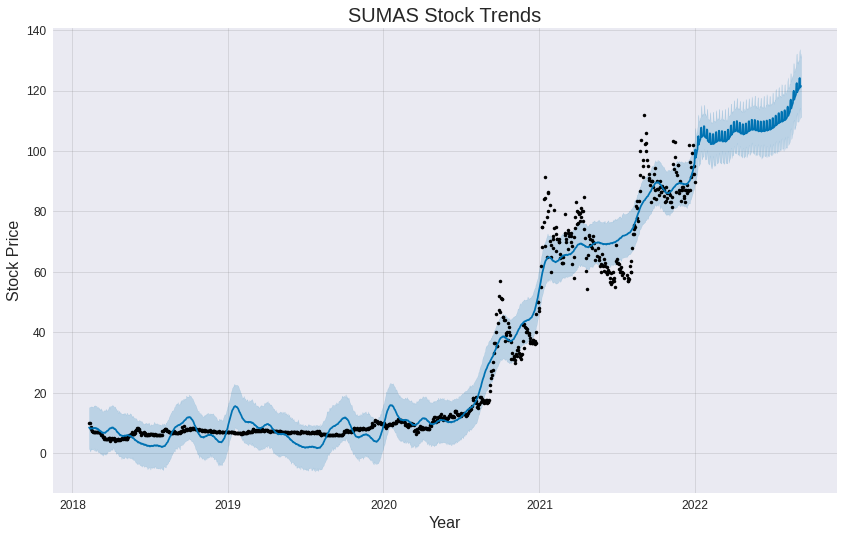

In [16]:
fig1=model.plot(predict,figsize=(12,7.5))
plt.title('SUMAS Stock Trends',fontsize=20)
plt.ylabel('Stock Price')
plt.xlabel('Year')

Text(0.5, 44.5, 'Year')

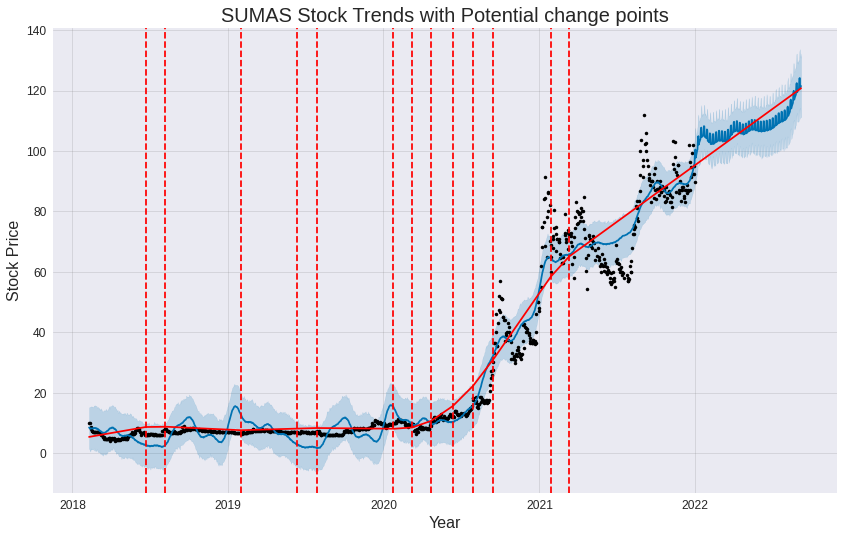

In [17]:
fig = model.plot(predict,figsize=(12,7.5))
a = add_changepoints_to_plot(fig.gca(), model, predict)
plt.title('SUMAS Stock Trends with Potential change points',fontsize=20)
plt.ylabel('Stock Price')
plt.xlabel('Year')

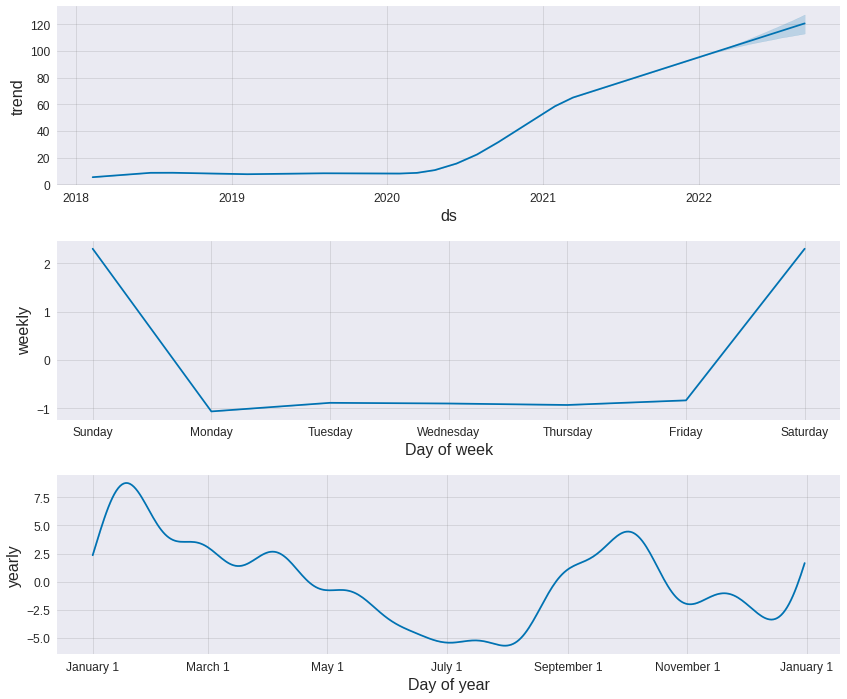

In [18]:
fig2=model.plot_components(predict,figsize=(12,10))

In [19]:
training_dataset=pd.read_csv('stock_history/SUMAS.IS/SUMAS.IS_2018_2021.csv')
training_data=training_dataset.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))  ##Normalising
training_data=sc.fit_transform(training_data)

#Scaling
X_train=[]
y_train=[]
for i in range(60,len(training_data)):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])

X_train= np.array(X_train)
y_train=np.array(y_train)    

X_train=X_train.reshape((len(training_data)-60),60,1)

In [20]:
regressor= Sequential()

#Adding LSTM layers

regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

#Compiling RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [21]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [22]:
test_dataset=pd.read_csv('stock_history/SUMAS.IS/SUMAS.IS_test_2022.csv')
real_stock_prices=test_dataset.iloc[:,1:2].values

In [23]:
predict_2022=predict[(predict['ds']>'2022-01-03') & (predict['ds']<'2022-09-09')][['ds','trend']]  ##Extracting 2020 prediction from linear Model
predict_2022=predict_2022.set_index('ds',drop=True)

Xt=test_dataset.set_index('Date',drop=True)  ##Ignoring the holidays
new=Xt.join(predict_2022)
linear_prediction=new['trend'].values.reshape(len(new),1)

In [24]:
total_dataset=pd.concat((training_dataset['Open'],test_dataset['Open']),axis=0)
inputs=total_dataset.iloc[len(total_dataset)-len(test_dataset)-60:].values
inputs=inputs.reshape(-1,1)

inputs=sc.transform(inputs)

X_test=[]
for i in range(60,(60+len(real_stock_prices))):
    X_test.append(inputs[i-60:i,0])
    
X_test= np.array(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

predicted_stock_values=regressor.predict(X_test)
predicted_stock_values=sc.inverse_transform(predicted_stock_values)

In [25]:
Year_2022=pd.DataFrame(np.concatenate((real_stock_prices,predicted_stock_values,linear_prediction),axis=1),index=test_dataset['Date'],columns=['Real','Predicted','Linear'])
Year_2022.index = pd.to_datetime(Year_2022.index)
Year_2022.tail()

,Real,Predicted,Linear
Date,,,
2022-09-05,80.050003,8.326786,NaN
2022-09-06,76.800003,8.340732,NaN
2022-09-07,77.000000,8.356400,NaN
2022-09-08,75.500000,8.373138,NaN
2022-09-09,75.000000,8.390030,NaN


In [27]:
groups_real = Year_2022['Real'].groupby(pd.Grouper(freq='M'))
groups_predict = Year_2022['Predicted'].groupby(pd.Grouper(freq='M'))

months_real = pd.concat([pd.DataFrame(x[1].values) for x in groups_real], axis=1)
months_predict = pd.concat([pd.DataFrame(x[1].values) for x in groups_predict], axis=1)

months_real = pd.DataFrame(months_real)
months_predict = pd.DataFrame(months_predict)

months_real.columns = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep']
months_predict.columns = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep']

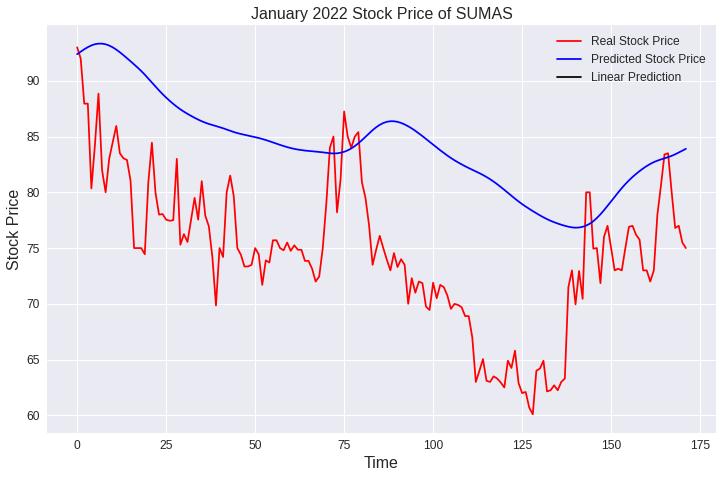

In [29]:
plt.figure(figsize=(12,7.5))
plt.plot(real_stock_prices,color='red',label='Real Stock Price')
plt.plot(predicted_stock_values*10,color='blue',label='Predicted Stock Price')
#plt.plot(predicted_stock_values_2,color='green',label='Predicted Google Stock Price_2')
plt.plot(linear_prediction,color='black',label='Linear Prediction')
plt.title('January 2022 Stock Price of SUMAS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

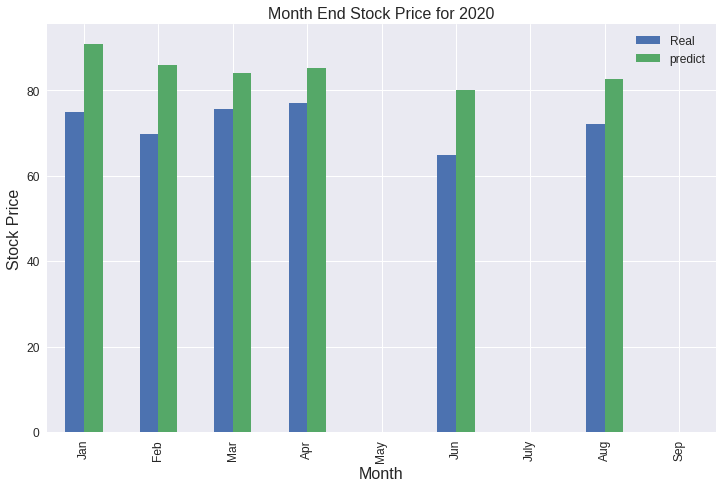

In [32]:
mon=pd.DataFrame({'Real':months_real[18:19].values.ravel(),'predict':months_predict[18:19].values.ravel()*10},index=months_real[18:19].columns)
mon.plot(kind='bar',figsize=(12,7.5))
plt.xlabel("Month")
plt.ylabel("Stock Price")
plt.title("Month End Stock Price for 2020")
plt.show()